# **Загрузка Датасета**

In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
face-expression-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip face-expression-recognition-dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.j

# **Необходимые для работы библиотеки**

In [ ]:
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os
import gc
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from glob import glob
from keras.preprocessing.image import img_to_array
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available: ", device)

Device available:  cuda


# **Предобработка данных**

Для Train и для Test приведем все изображения к единому формату, конвертируем в тензор и нормализуем.

In [ ]:
transform_train = transforms.Compose([
         transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
         transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

# **Загрузка данных**

Создаем наш загрузчик данных и присваиваем соответствующие папки train_data и train_test

In [ ]:
class MyDataset(Dataset):

  def __init__(self, path, transform=None):
    self.path = path
    self.transform = transform

    self.len_dataset = 0
    self.data_list = []

    for path_dir, dir_list, file_list in os.walk(path):
      if path_dir == path:
        self.classes = sorted(dir_list)
        self.class_to_idx = {
          cls_name: i for i, cls_name in enumerate(self.classes)
          }
        continue

      cls = path_dir.split('/')[-1]

      for name_file in file_list:
        file_path = os.path.join(path_dir, name_file)
        self.data_list.append((file_path, self.class_to_idx[cls]))

      self.len_dataset += len(file_list)

  def __len__(self):
    return self.len_dataset

  def __getitem__(self, index):
    file_path, target = self.data_list[index]
    sample = np.array(Image.open(file_path))

    if self.transform is not None:
      sample = self.transform(sample)

    return sample, target

Посмотрим какие папки и сколько файлов есть в Train нашего Датасета и выведем пути к папкам

In [ ]:
for path, dir_list, file_list in os.walk('/content/images/images/train'):
  print(f'Путь к папке - {path}')
  print(f'  -- кол-во папок {len(dir_list)}')
  print(f'  -- кол-во файлов {len(file_list)}')

Путь к папке - /content/images/images/train
  -- кол-во папок 7
  -- кол-во файлов 0
Путь к папке - /content/images/images/train/surprise
  -- кол-во папок 0
  -- кол-во файлов 3205
Путь к папке - /content/images/images/train/sad
  -- кол-во папок 0
  -- кол-во файлов 4938
Путь к папке - /content/images/images/train/happy
  -- кол-во папок 0
  -- кол-во файлов 7164
Путь к папке - /content/images/images/train/neutral
  -- кол-во папок 0
  -- кол-во файлов 4982
Путь к папке - /content/images/images/train/angry
  -- кол-во папок 0
  -- кол-во файлов 3993
Путь к папке - /content/images/images/train/fear
  -- кол-во папок 0
  -- кол-во файлов 4103
Путь к папке - /content/images/images/train/disgust
  -- кол-во папок 0
  -- кол-во файлов 436


Посмотрим распределение файлов по папкам:
- всего у нас 7 класов - 7 эмоций
- есть класс с очень маленьким количеством файлов - disgust (436)
- есть класс с очень большим количеством файлов - happy (7164)

In [ ]:
for path, dir_list, file_list in os.walk('/content/images/images/train'):
  print(f'Класс - {path.split("/")[-1]}')
  print(f'  -- кол-во файлов {len(file_list)}')

Класс - train
  -- кол-во файлов 0
Класс - surprise
  -- кол-во файлов 3205
Класс - sad
  -- кол-во файлов 4938
Класс - happy
  -- кол-во файлов 7164
Класс - neutral
  -- кол-во файлов 4982
Класс - angry
  -- кол-во файлов 3993
Класс - fear
  -- кол-во файлов 4103
Класс - disgust
  -- кол-во файлов 436


Создадим тренировочный и Тестовый Датасеты:

In [ ]:
train_data = datasets.ImageFolder("/content/images/images/train", transform=transform_train, )
test_data = datasets.ImageFolder("/content/images/images/validation", transform=transform_val)

Посмотрим какие классы у нас есть:

In [ ]:
train_data.classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Позиция класса в one_hot_vector:

In [ ]:
train_data.class_to_idx

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

И посмотрим как выглядит one_hot_vector для каждого класса:

In [ ]:
for cls, one_hot_position in train_data.class_to_idx.items():
  one_hot_vector = [(i == one_hot_position)*1 for i in range(7)]
  print(f"\033[32m{cls}\033[0m => \033[34m{one_hot_vector}\033[0m")

angry => [1, 0, 0, 0, 0, 0, 0]
disgust => [0, 1, 0, 0, 0, 0, 0]
fear => [0, 0, 1, 0, 0, 0, 0]
happy => [0, 0, 0, 1, 0, 0, 0]
neutral => [0, 0, 0, 0, 1, 0, 0]
sad => [0, 0, 0, 0, 0, 1, 0]
surprise => [0, 0, 0, 0, 0, 0, 1]


Проверим работу функции len. Количеcтво файлов совпадает с указанным в описании Датасета на Kaggle.

In [ ]:
print(f"Длина Train: {len(train_data)}")
print(f"Длина Test: {len(test_data)}")

Длина Train: 28821
Длина Test: 7066


Проверим работу функции getitem. На выходе получаем кортеж и номер класса.

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 28821
    Root location: /content/images/images/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
train_data[256]

(tensor([[[ 1.8208,  1.8208,  1.8208,  ...,  1.0159,  1.0159,  1.0159],
          [ 1.8208,  1.8208,  1.8208,  ...,  1.0159,  1.0159,  1.0159],
          [ 1.8208,  1.8208,  1.8208,  ...,  1.0159,  1.0159,  1.0159],
          ...,
          [-1.5528, -1.5528, -1.5528,  ..., -2.1179, -2.1179, -2.1179],
          [-1.5528, -1.5528, -1.5528,  ..., -2.1179, -2.1179, -2.1179],
          [-1.5528, -1.5528, -1.5528,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[ 1.9909,  1.9909,  1.9909,  ...,  1.1681,  1.1681,  1.1681],
          [ 1.9909,  1.9909,  1.9909,  ...,  1.1681,  1.1681,  1.1681],
          [ 1.9909,  1.9909,  1.9909,  ...,  1.1681,  1.1681,  1.1681],
          ...,
          [-1.4580, -1.4580, -1.4580,  ..., -2.0357, -2.0357, -2.0357],
          [-1.4580, -1.4580, -1.4580,  ..., -2.0357, -2.0357, -2.0357],
          [-1.4580, -1.4580, -1.4580,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[ 2.2043,  2.2043,  2.2043,  ...,  1.3851,  1.3851,  1.3851],
          [ 2.2043,  2.2043,

Выведем какую-нибудь картинку для проверки соответствия классу:

Класс - angry


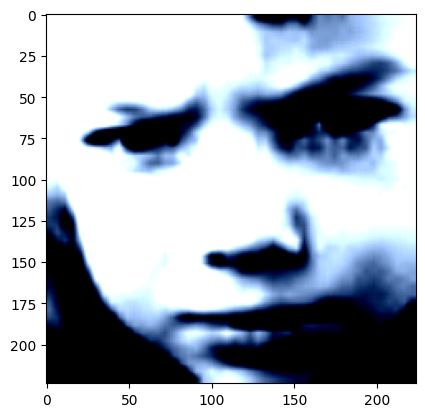

In [ ]:
img, one_hot_position = train_data[256]

cls = train_data.classes[one_hot_position]
print(f'Класс - {cls}')
plt.imshow(img.permute(1, 2, 0), cmap = 'gray')

Разобьем данные на батчи и проверим размерность батчей в Train:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle = True, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle = False, pin_memory=True, num_workers=2)

In [ ]:
for batch in train_loader:
    images, labels = batch
    print(f"Размерности батча изображений: {images.size()}")
    print(f"Размерности батча меток: {labels.size()}")
    break

Размерности батча изображений: torch.Size([32, 3, 224, 224])
Размерности батча меток: torch.Size([32])


Посмотрим на примеры картинок из датасета и проверим что объявили даталоадеры верно:

In [ ]:
test_dataiter = iter(test_loader)
images, labels = next(test_dataiter)

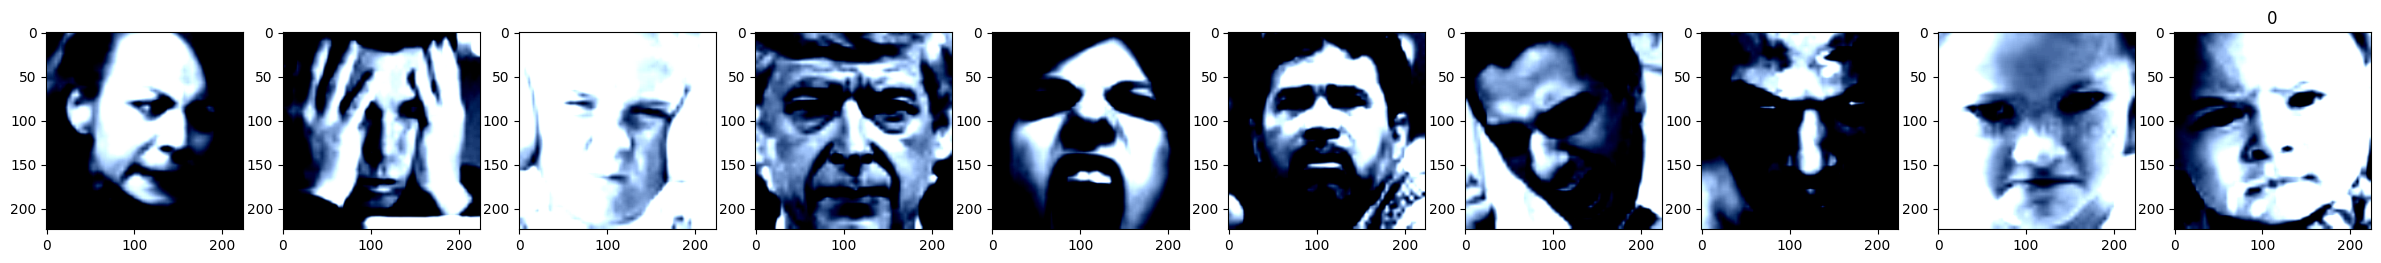

In [ ]:
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
    axes[i].set_title(labels[i].numpy())
plt.show()

show_imgs(images, labels)

# **Дообучение модели VGG16**

Загрузим саму модель VGG16:

In [ ]:
vgg16 = models.vgg16(pretrained=True)

Обрезаем последний слой:

In [ ]:
vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children()))[:-1]

In [ ]:
vgg16.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): ReLU(inplace=True)
    (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (20): ReLU(inplace=True)
    (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (22): ReLU(inplace=True)
    (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (25): ReLU(inplace=True)
    (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (27): ReLU(inplace=True)
    (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (29): ReLU(inplace=True)
    (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
  )
)>

Объявим класс для модели:

In [ ]:
class New_VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg16 = vgg16 # вся огромная нейросеть в одну строчку
        for param in self.vgg16.features.parameters(): # отключаем для нее обновление параметров
            param.requires_grad = False
        self.fc = nn.Linear(4096, 7) # добавляем новый слой с нужным кол-во лейблов - 7 шт.

    def forward(self, x):
        # forward pass сети
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = self.vgg16(x)
        x = self.fc(x)
        return x

In [ ]:
torch.cuda.empty_cache()

In [ ]:
gc.collect()

520

Код обучения нашей сети:

In [ ]:
def train(net, n_epoch=10):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # acc по test
    best_accuracy = 0
    # обучаем сеть 10 эпох
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0

        for i, batch in enumerate(tqdm(train_loader)):
            # так получаем текущий батч
            X_batch, y_batch = batch
            # переносим его на видеопамять
            # если точно уверены, что это гпу - можно написать .cuda()
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # обнуляем веса
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)

            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
            # bsckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()

            # проверяем качество каждые 1500 батчей (~пол эпохи)
            if i % 1500 ==0:
                # менеджер упарвления контекстом торча указывает на то, чтобы не обновлять параметры
                with torch.no_grad():
                    accuracy = []
                    for batch in test_loader:
                        x, y = batch
                        # переносим на гпу
                        x = x.to(device)
                        y = y.to(device)
                        # прогнозируем
                        y_pred = net(x)
                        # loss = loss_fn(y_pred, y)
                        # находим accuracy батча с теста
                        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
                    # усредняем accuracy всех батчей на тесте
                    accuracy = np.mean(np.array(accuracy))
                    # если стало лучше - сохраняем на диск и обновляем лучшую метрику
                    if accuracy > best_accuracy:
                        print('New best model with test acc:', accuracy)
                        torch.save(net.state_dict(), './best_model.pt')
                        best_accuracy = accuracy

            # выведем текущий loss
            running_loss += loss.item()
            # выведем качество каждые 500 батчей
            if i % 500 == 499:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0

    print('Обучение закончено')
    return net

In [ ]:
device=torch.device('cuda')

net = New_VGG16().to(device)
train(net)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


New best model with test acc: 0.1686825617821093
[1,   500] loss: 1.060


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/901 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


New best model with test acc: 0.5381787330316742
[2,   500] loss: 0.853


  0%|          | 0/901 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[3,   500] loss: 0.708


  0%|          | 0/901 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[4,   500] loss: 0.561


  0%|          | 0/901 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


New best model with test acc: 0.5648277062304212
[5,   500] loss: 0.462


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/901 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


New best model with test acc: 0.5650996345283675
[6,   500] loss: 0.409


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/901 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[7,   500] loss: 0.358


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/901 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


New best model with test acc: 0.5698094326487991
[8,   500] loss: 0.319


  0%|          | 0/901 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


New best model with test acc: 0.5773364079359555
[9,   500] loss: 0.303


  0%|          | 0/901 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[10,   500] loss: 0.266
Обучение закончено


New_VGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [ ]:
labels_net = []
labels_true = []
for images, labels in test_loader:
    labels_true.extend(labels)
    labels_net.extend(net.forward(images.cuda()).detach().cpu().numpy())

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
accuracy_score(labels_true, np.argmax(np.array(labels_net), axis=1))

0.5642513444664591

In [ ]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images.cuda()).detach().cpu().numpy(), axis=1))

0.6153846153846154

Результаты, конечно, так себе, но цель была попробовать дообучить уже готовую модель, реализовать свой загрузчик данных и посмотреть в целом на решение подобных задач.